Moirai
===
is a flexible model for time series forecasting developed by Salesforce. It is designed as a universal model capable of predicting a wide range of time series; it owns the ability to:

- Handle all kinds of data frequencies (hourly, daily, weekly, etc);
- Accommodate any number and types of covariates, whether they are unknown in the future or known;
- Generate a probabilistic forecast using a flexible distribution that can be adapted to several cases.



- [Article](https://towardsdatascience.com/moirai-time-series-foundation-models-for-universal-forecasting-dc93f74b330f)
- [SaleForce Morai](https://github.com/zaai-ai/lab/blob/main/forecasting/MOIRAI-walmart/moirai.ipynb)
- [Walmark data](https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast/data?select=features.csv)

In [ ]:
!pip install git+https://github.com/SalesforceAIResearch/uni2ts.git

In [1]:
# clear the output 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import numpy as np
import utils

from datetime import timedelta
from gluonts.dataset.pandas import PandasDataset
from huggingface_hub import hf_hub_download

from uni2ts.model.moirai import MoiraiForecast


2024-04-12 11:44:35.471791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
TIME_COL = "Date"
TARGET = "Weekly_Sales"
DYNAMIC_COV = ["IsHoliday", 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
FORECAST_HORIZON = 17 # weeks
FREQ = "W-FRI"

In [4]:
# load data and exogenous features
df = pd.read_csv('data/train.csv.zip')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

# create unique id
df["unique_id"] = df['Store'].astype(str)+'-'+df['Dept'].astype(str)

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df.head(2)

Distinct number of time series: 3331


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,unique_id
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1-1
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1-1


Pre-process dataset
---
- Clean up data
- Select top 7 stores for forecasting

In [5]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
                "medium")) # make size a categorical variable

# reduce running time by forecasting only top 100 stores-depts
top_100_stores = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(100)
df = df[df['unique_id'].isin(top_100_stores['unique_id'])]

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df.head()

Distinct number of time series: 100


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,unique_id
5118,1,38,2010-02-05,115564.35,0,A,medium,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1-38
5119,1,38,2010-02-12,94136.35,1,A,medium,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,1-38
5120,1,38,2010-02-19,98672.59,0,A,medium,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,1-38
5121,1,38,2010-02-26,92755.59,0,A,medium,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,1-38
5122,1,38,2010-03-05,108282.86,0,A,medium,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,1-38


In [6]:
# Split data
# 17 weeks to test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-timedelta(weeks=FORECAST_HORIZON))]

# since we have several time series not all of them have the same number of weeks in the forecast set
print(f"Weeks for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Weeks for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Weeks for training: 126 from 2010-02-05 to 2012-06-29
Weeks for testing: 17 from 2012-07-06 to 2012-10-26


In [7]:
# create GluonTS dataset from pandas
ds = PandasDataset.from_long_dataframe(
    pd.concat([train, test[["unique_id", TIME_COL]+DYNAMIC_COV]]).set_index(TIME_COL), # concatenation with test dynamic covaraiates
    item_id="unique_id",
    feat_dynamic_real=DYNAMIC_COV,
    target=TARGET,
    freq=FREQ
)

In [ ]:
# Moirai 
# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id=f"Salesforce/moirai-R-large", filename="model.ckpt"
    ),
    prediction_length=FORECAST_HORIZON,
    context_length=52,
    patch_size='auto',
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(ds)

# convert forecast into pandas
forecast_df = utils.moirai_forecast_to_pandas(forecasts, test, FORECAST_HORIZON, TIME_COL)

model.ckpt:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

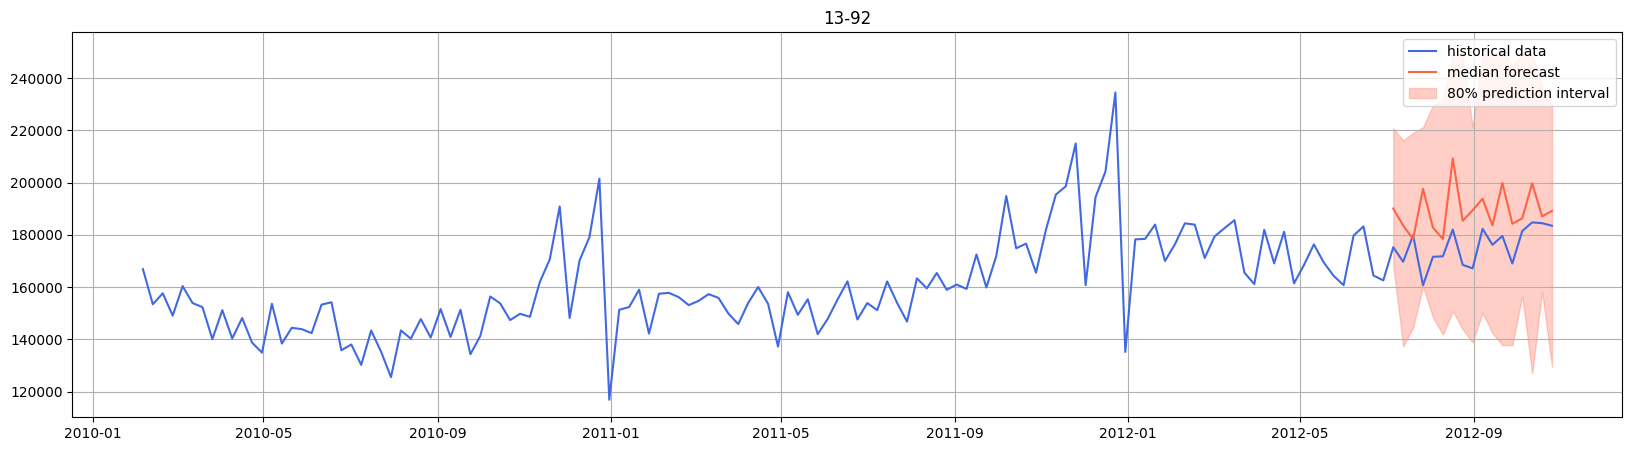

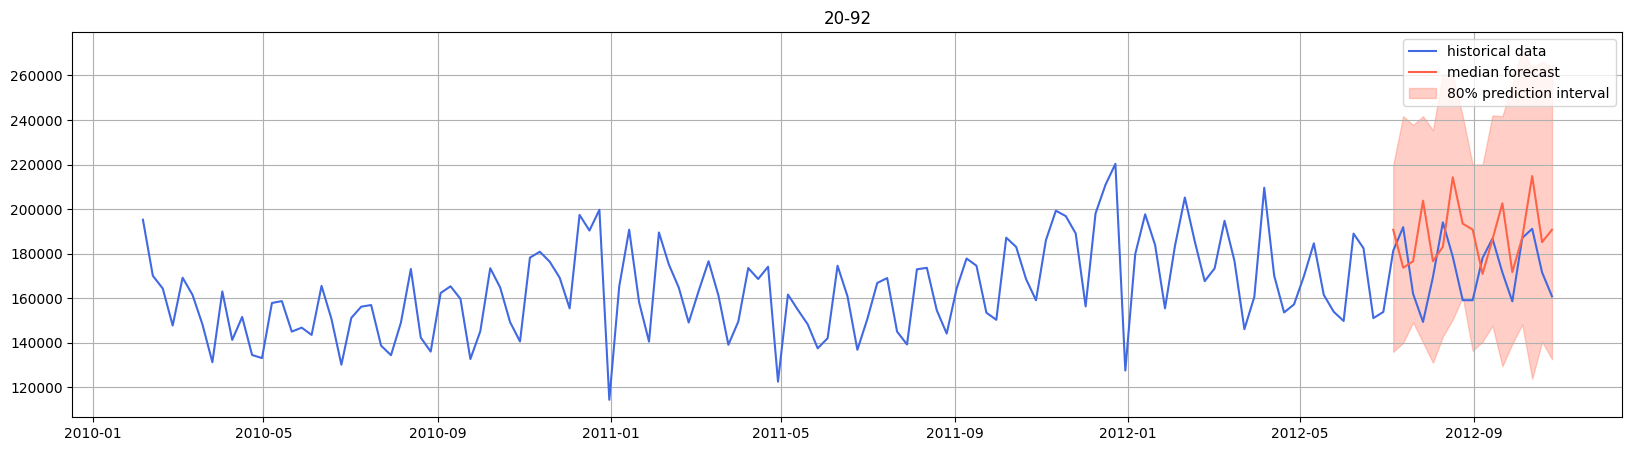

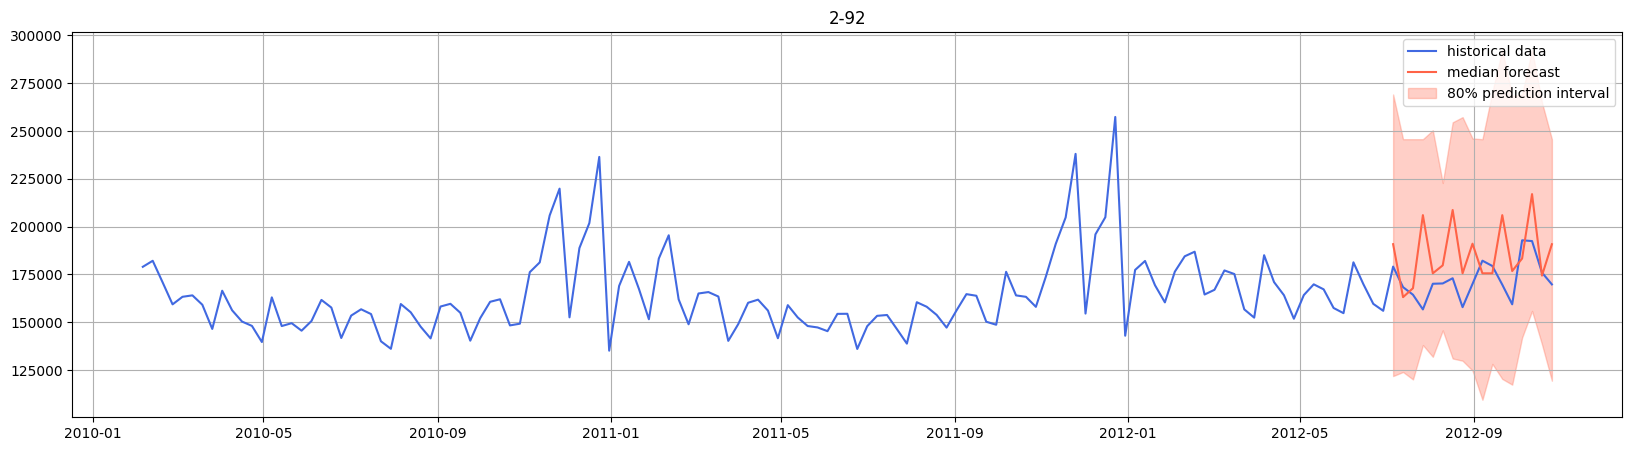

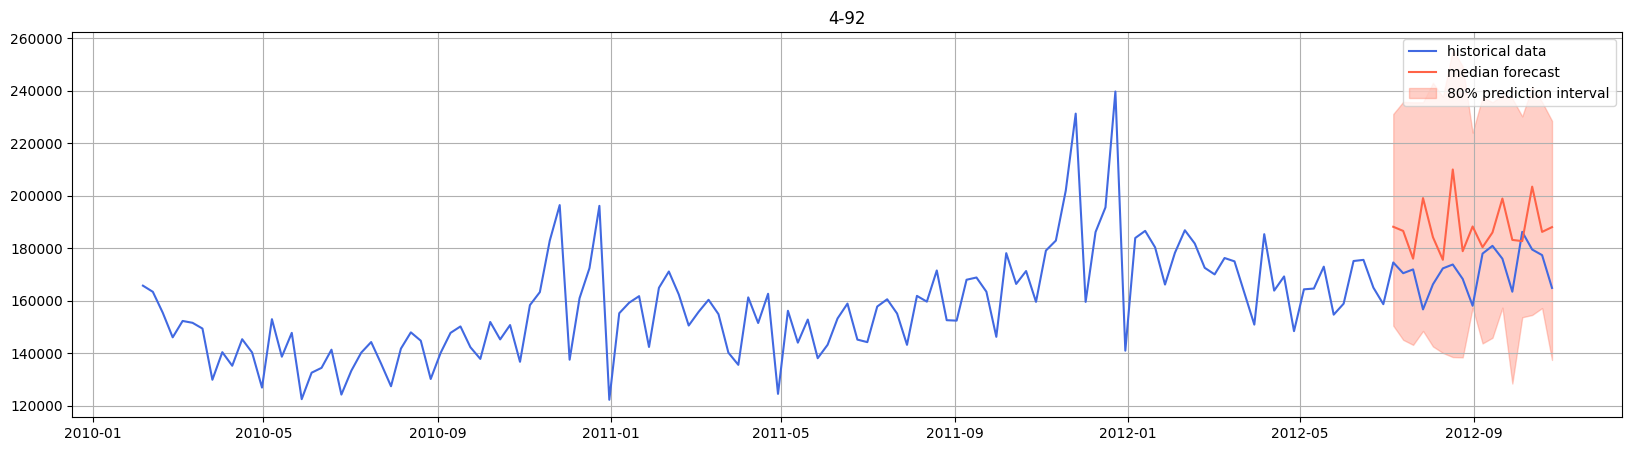

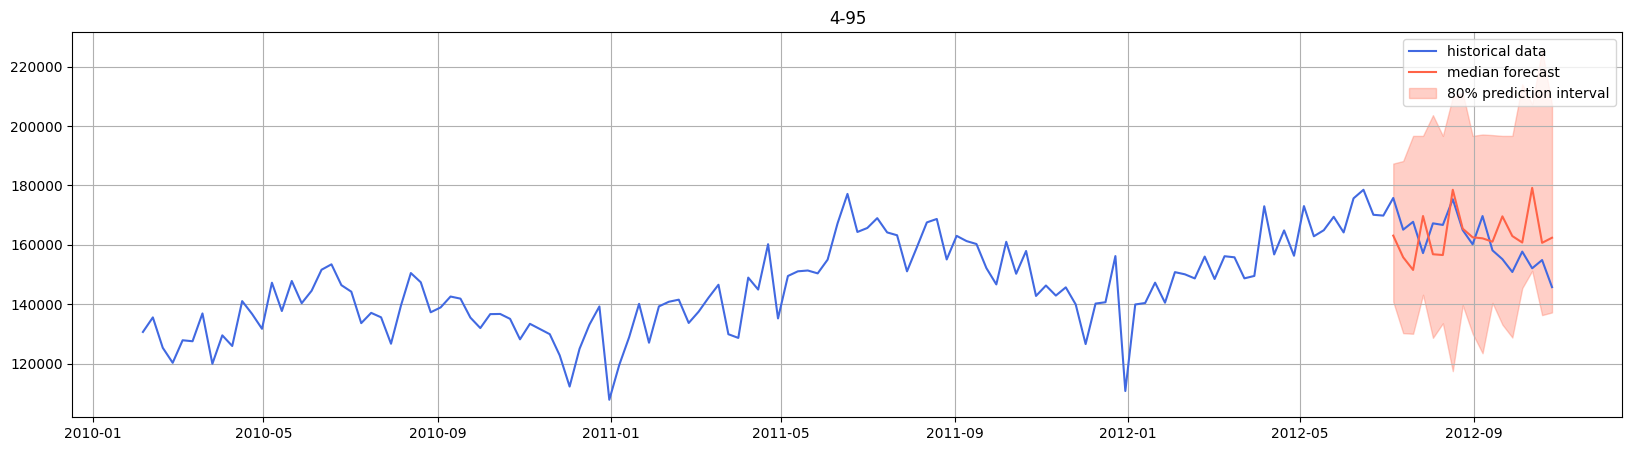

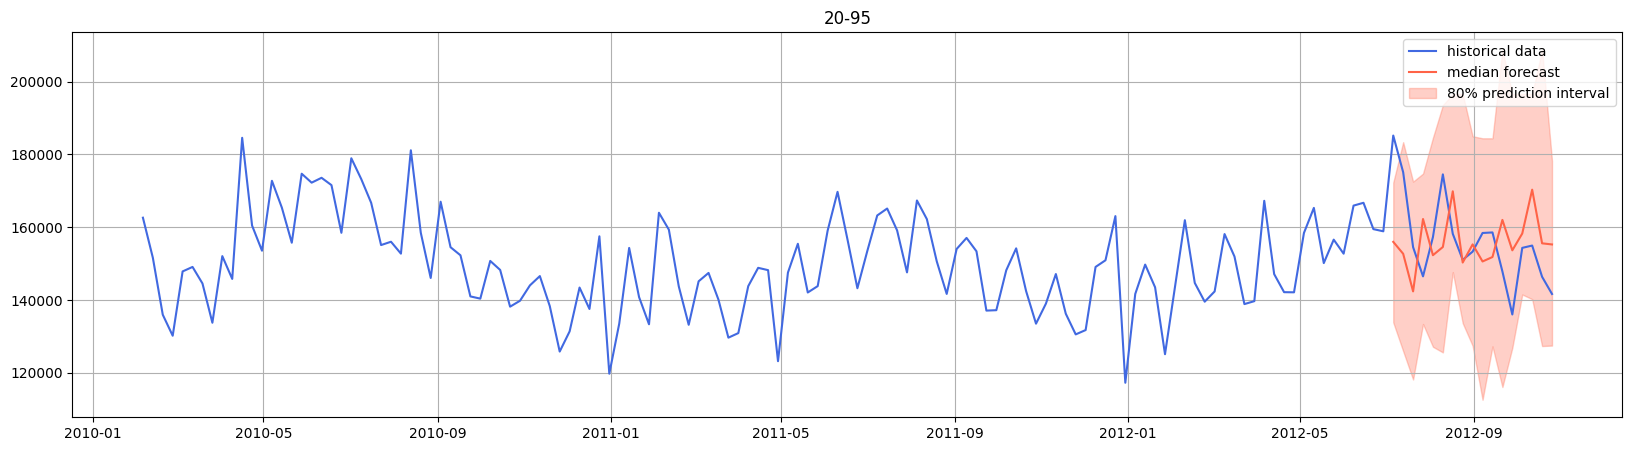

In [9]:
# get series ordered by volume in a descending way
series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)['unique_id'].tolist()

for ts in series[:6]:
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_df[forecast_df["unique_id"] == ts], ts)

In [16]:
# Model Evaluation
# load the forecast from tide, chronos and moirai
#tide_model_df = pd.read_csv('data/tide.csv.zip', parse_dates=['Date'])
#chronos_large_df = pd.read_csv('data/chronos_large.csv', parse_dates=['Date'])
#moirai_df = pd.read_csv('data/moirai.csv', parse_dates=['Date'])

# merge data frames with forecast and actuals
#model_eval_df = pd.merge(test[['unique_id', 'Date', TARGET]], tide_model_df[['unique_id', 'Date', 'TiDE']], on=['unique_id', 'Date'], how='inner')
#model_eval_df = pd.merge(model_eval_df, chronos_large_df[['unique_id', 'Date', 'Chronos Large']], on=['unique_id', 'Date'], how='inner')
#model_eval_df = pd.merge(model_eval_df, moirai_df[['unique_id', 'Date', 'MOIRAI']], on=['unique_id', 'Date'], how='inner')

#utils.plot_model_comparison(model_eval_df)
utils.plot_model_comparison(moirai_df)

KeyError: 'Weekly_Sales'

In [13]:
forecast_df

,unique_id,Date,forecast,forecast_lower,forecast_upper
0,1-38,2012-07-06,87341.351562,50773.170312,114585.140625
1,1-38,2012-07-13,79060.328125,58529.471094,104458.088281
2,1-38,2012-07-20,77139.406250,55345.712500,114585.140625
3,1-38,2012-07-27,94527.609375,64301.478125,126749.571875
4,1-38,2012-08-03,80131.453125,51936.300000,123247.739063
...,...,...,...,...,...
1695,9-38,2012-09-28,83130.414062,64987.619141,113285.848438
1696,9-38,2012-10-05,84645.273438,70753.003906,123350.000000
1697,9-38,2012-10-12,100014.359375,65338.696875,123350.000000
1698,9-38,2012-10-19,86514.359375,61127.245313,123350.000000


<Axes: >

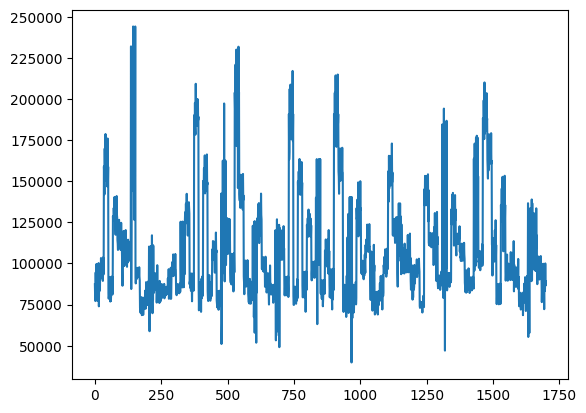

In [18]:
moirai_df['forecast'].plot()